# 1. Baseline Machine Learning Classification Model

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Define data directories
data_dir = r'C:\Users\ianis\Desktop\PolyMtl\Cours\Hiv26\INF6422E\Lab2\cifar-10-python'  # Update with your local path


# Data transformation
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),  # Adding vertical flip
    #transforms.RandomRotation(20),    # Adding random rotation
    #transforms.RandomAffine(15),      # Adding random affine transformation
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [79]:
# Load datasets
full_dataset = datasets.CIFAR10(root=data_dir, transform=data_transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [80]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        #self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # Updated to match the expected input size
        #self.fc1 = nn.Linear(512 * 1 * 1, 512)  # Updated to match the expected input size after 5 conv layers
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        #x = self.pool(self.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Check the model architecture
model = SimpleCNN(num_classes=10)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [81]:
import torch
print("Torch version:", torch.__version__)
print("CUDA in torch:", torch.version.cuda)


# Check if GPU is available
print(torch.cuda.is_available())

Torch version: 2.10.0+cu128
CUDA in torch: 12.8
True


In [82]:
# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    for class_idx in range(len(class_total)):
        accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
        print(f"Validation Accuracy for class {class_idx}: {accuracy:.2f}%")


Epoch 1/10, Train Loss: 1.5853, Val Loss: 1.2628, Val Accuracy: 54.00%
Validation Accuracy for class 0: 46.75%
Validation Accuracy for class 1: 66.09%
Validation Accuracy for class 2: 23.74%
Validation Accuracy for class 3: 48.17%
Validation Accuracy for class 4: 49.15%
Validation Accuracy for class 5: 40.65%
Validation Accuracy for class 6: 72.36%
Validation Accuracy for class 7: 45.19%
Validation Accuracy for class 8: 70.28%
Validation Accuracy for class 9: 77.54%
Epoch 2/10, Train Loss: 1.1398, Val Loss: 0.9592, Val Accuracy: 65.67%
Validation Accuracy for class 0: 59.62%
Validation Accuracy for class 1: 78.10%
Validation Accuracy for class 2: 60.31%
Validation Accuracy for class 3: 53.59%
Validation Accuracy for class 4: 49.58%
Validation Accuracy for class 5: 50.72%
Validation Accuracy for class 6: 73.04%
Validation Accuracy for class 7: 66.14%
Validation Accuracy for class 8: 83.53%
Validation Accuracy for class 9: 80.71%
Epoch 3/10, Train Loss: 0.9102, Val Loss: 0.9101, Val Accu

In [83]:
# Save the trained model
torch.save(model.state_dict(), 'cnn_project_4cnn.pth')
print("Model saved as cnn_project_4cnn.pth")

Model saved as cnn_project_4cnn.pth


In [84]:
# Load the trained model
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('cnn_project_4cnn.pth'))

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

# Evaluate on the test set
correct = 0
total = 0
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

for class_idx in range(len(class_total)):
    accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
    print(f"Test Accuracy for class {class_idx}: {accuracy:.2f}%")

Test Accuracy: 73.47%
Test Accuracy for class 0: 79.71%
Test Accuracy for class 1: 90.09%
Test Accuracy for class 2: 60.00%
Test Accuracy for class 3: 57.89%
Test Accuracy for class 4: 62.65%
Test Accuracy for class 5: 71.71%
Test Accuracy for class 6: 82.72%
Test Accuracy for class 7: 64.18%
Test Accuracy for class 8: 82.35%
Test Accuracy for class 9: 83.52%


In [85]:
# Get predictions and calculate probabilities for ROC and Precision-Recall curves
all_labels = []
all_outputs = []
all_outputs_proba = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(predicted.cpu().numpy())
        all_outputs_proba.extend(outputs.cpu().numpy())

all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)
all_outputs_proba = np.array(all_outputs_proba)

# Get class names from the original dataset
class_names = full_dataset.classes

Normalized confusion matrix


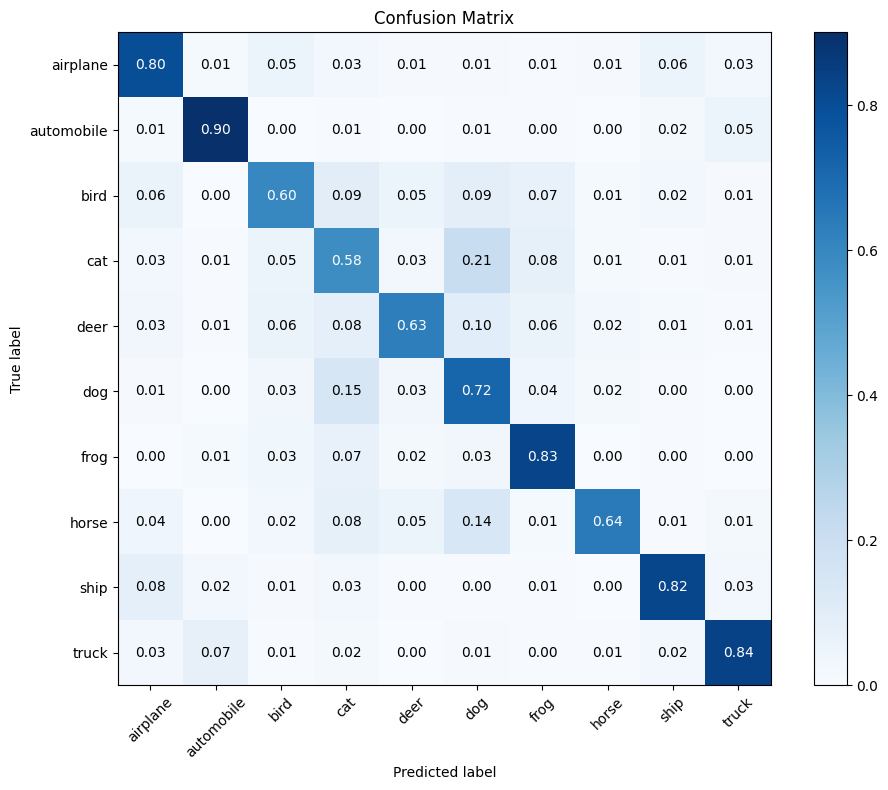

Classification Report:
               precision    recall  f1-score   support

    airplane       0.74      0.80      0.77       754
  automobile       0.87      0.90      0.89       757
        bird       0.68      0.60      0.64       705
         cat       0.52      0.58      0.55       760
        deer       0.77      0.63      0.69       755
         dog       0.56      0.72      0.63       774
        frog       0.75      0.83      0.78       729
       horse       0.89      0.64      0.75       779
        ship       0.85      0.82      0.83       759
       truck       0.85      0.84      0.84       728

    accuracy                           0.73      7500
   macro avg       0.75      0.73      0.74      7500
weighted avg       0.75      0.73      0.74      7500



In [86]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_outputs)
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Classification Report
class_report = classification_report(all_labels, all_outputs, target_names=class_names, zero_division=0)
print("Classification Report:\n", class_report)

# Binarize labels for ROC and Precision-Recall curves
y_test_binarized = label_binarize(all_labels, classes=np.arange(len(class_names)))
if y_test_binarized.shape[1] == 1:
    y_test_binarized = np.hstack([1 - y_test_binarized, y_test_binarized])

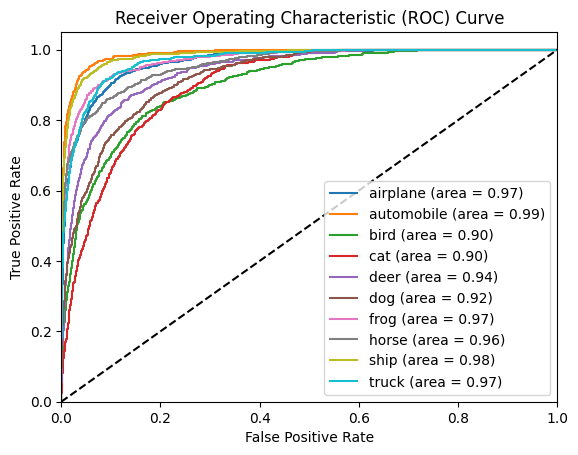

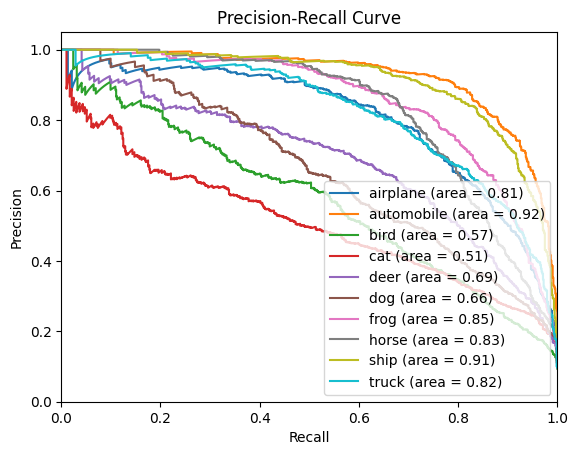

In [87]:
def plot_roc_curve_multiclass(y_true, y_pred_proba, n_classes, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve_multiclass(y_true, y_pred_proba, n_classes, class_names):
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'{class_names[i]} (area = {pr_auc[i]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for each class
plot_roc_curve_multiclass(y_test_binarized, all_outputs_proba, len(class_names), class_names)

# Plot Precision-Recall curve for each class
plot_precision_recall_curve_multiclass(y_test_binarized, all_outputs_proba, len(class_names), class_names)

# 2. Adversarial Evasion Attacks (Test-Time Threats)
## 2.1 FGSM Attack Implementation


In [185]:
def fgsm_attack(image, epsilon, data_grad):
    # Sign of gradient
    sign_grad = data_grad.sign()
    # Create adversarial image
    perturbed_image = image + epsilon * sign_grad
    # Clip to valid pixel range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # /!\ Note: Since the images are normalized, clipping to [0, 1] is not correct.

    return perturbed_image


In [190]:
## Apply FGSM attack on a sample from the test set

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
# Enable gradient computation
images.requires_grad = True
# Forward pass
outputs = model(images)
# Compute loss
loss = criterion(outputs, labels)
# Backward pass
model.zero_grad()
loss.backward()
# Collect gradient of input
data_grad = images.grad.data
# Generate adversarial batches
epsilon = [0, 0.005, 0.01, 0.03, 0.05, 0.06]  # You can experiment with different epsilon values
adv_outputs = []
adv_images_list = []

for eps in epsilon:
    adv_images = fgsm_attack(images, eps, data_grad)
    adv_images_list.append(adv_images)
    # Re-classify adversarial examples
    adv_outputs.append(model(adv_images))

# Compare predictions
pred_adv_list = []
_, pred_clean = torch.max(outputs, 1)
for i in range(len(epsilon)):
    _, pred_adv = torch.max(adv_outputs[i], 1)
    pred_adv_list.append(pred_adv)

print("Clean predictions:", pred_clean[:5])
for i, eps in enumerate(epsilon):
    print(f"Adversarial predictions (epsilon={eps}):", pred_adv_list[i][:5])

Clean predictions: tensor([2, 1, 5, 1, 2], device='cuda:0')
Adversarial predictions (epsilon=0): tensor([2, 1, 5, 1, 2], device='cuda:0')
Adversarial predictions (epsilon=0.005): tensor([2, 9, 5, 1, 2], device='cuda:0')
Adversarial predictions (epsilon=0.01): tensor([3, 9, 5, 1, 2], device='cuda:0')
Adversarial predictions (epsilon=0.03): tensor([3, 3, 5, 9, 2], device='cuda:0')
Adversarial predictions (epsilon=0.05): tensor([3, 3, 5, 9, 2], device='cuda:0')
Adversarial predictions (epsilon=0.06): tensor([3, 3, 5, 9, 2], device='cuda:0')


In [191]:
from sklearn.metrics import accuracy_score

accuracy_clean = accuracy_score(labels.cpu(), pred_clean.cpu())
accuracy_adv = []
for i in range(len(epsilon)):
    accuracy_adv.append(accuracy_score(labels.cpu(), pred_adv_list[i].cpu()))

print (f"Accuracy on clean examples: {accuracy_clean:.4f}")
for i, eps in enumerate(epsilon):
    print(f"Accuracy on adversarial examples (epsilon={eps}): {accuracy_adv[i]:.4f}")

Accuracy on clean examples: 0.7188
Accuracy on adversarial examples (epsilon=0): 0.7188
Accuracy on adversarial examples (epsilon=0.005): 0.4688
Accuracy on adversarial examples (epsilon=0.01): 0.3750
Accuracy on adversarial examples (epsilon=0.03): 0.2188
Accuracy on adversarial examples (epsilon=0.05): 0.0938
Accuracy on adversarial examples (epsilon=0.06): 0.0938


In [192]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(img_tensor, title=""):
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # C,H,W → H,W,C
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")



Example 20 with epsilon=0:
----------------------------------------
Clean predictions: 7 (horse)
Adversarial predictions: 7 (horse)
max |Δ|: 0.0


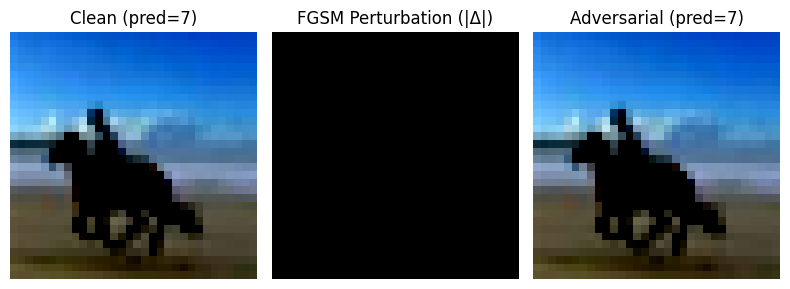


Example 20 with epsilon=0.005:
----------------------------------------
Clean predictions: 7 (horse)
Adversarial predictions: 2 (bird)
max |Δ|: 0.005000002682209015


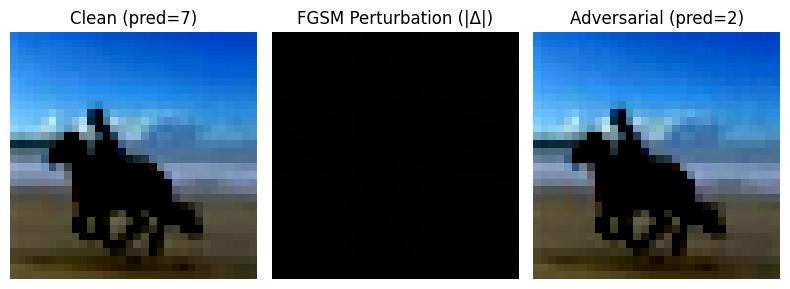


Example 20 with epsilon=0.01:
----------------------------------------
Clean predictions: 7 (horse)
Adversarial predictions: 2 (bird)
max |Δ|: 0.01000000536441803


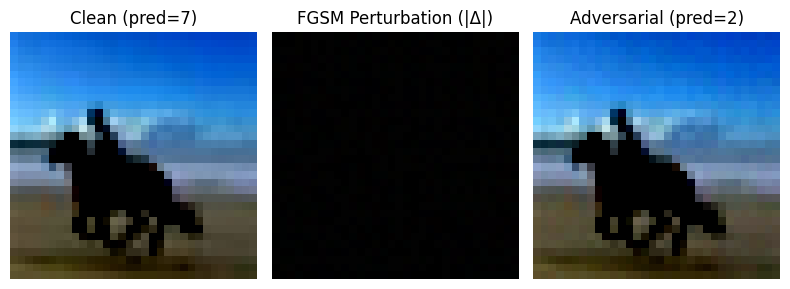


Example 20 with epsilon=0.03:
----------------------------------------
Clean predictions: 7 (horse)
Adversarial predictions: 2 (bird)
max |Δ|: 0.030000001192092896


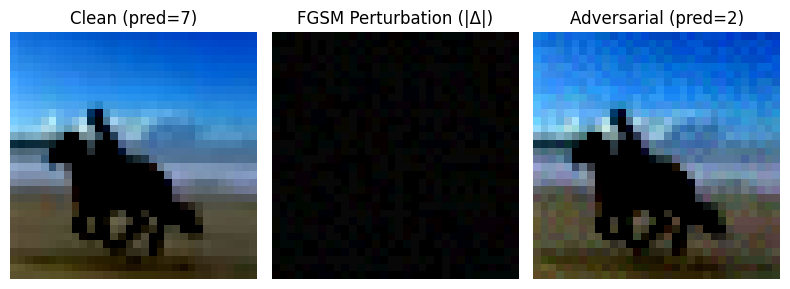


Example 20 with epsilon=0.05:
----------------------------------------
Clean predictions: 7 (horse)
Adversarial predictions: 2 (bird)
max |Δ|: 0.050000011920928955


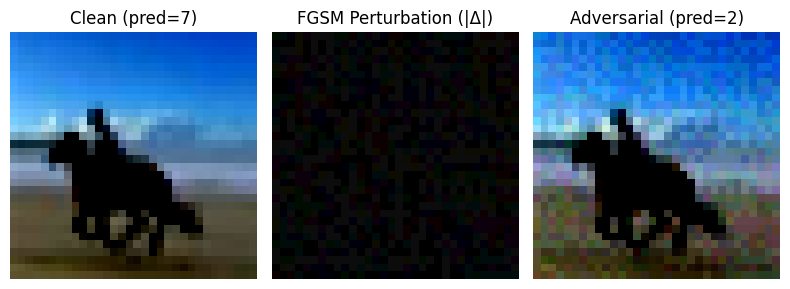


Example 20 with epsilon=0.06:
----------------------------------------
Clean predictions: 7 (horse)
Adversarial predictions: 2 (bird)
max |Δ|: 0.06000000238418579


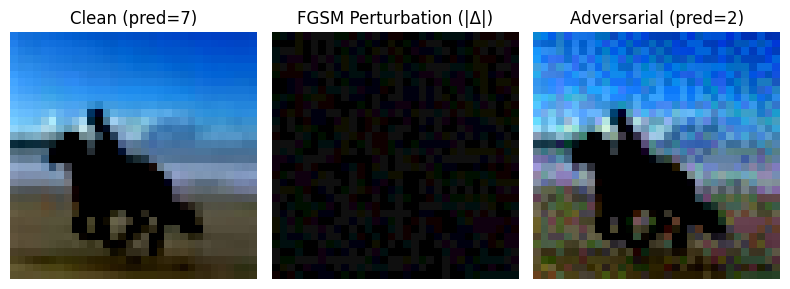

In [193]:
idx = 20  # choose which image to display

for i, eps in enumerate(epsilon):
    print(f"\nExample {idx} with epsilon={eps}:")
    print("----------------------------------------")
    print(f"Clean predictions:", pred_clean[idx].item(), f"({ class_names[pred_clean[idx].item()]})")
    print(f"Adversarial predictions:", pred_adv_list[i][idx].item(), f"({ class_names[pred_adv_list[i][idx].item()]})")
    
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    show_image(images[idx], title=f"Clean (pred={pred_clean[idx].item()})")

    perturbation = adv_images_list[i][idx] - images[idx]
    #print(perturbation)
    print("max |Δ|:", perturbation.abs().max().item())
    
    plt.subplot(1, 3, 2)
    show_image(perturbation, title="FGSM Perturbation (|Δ|)")

    plt.subplot(1, 3, 3)
    show_image(adv_images_list[i][idx], title=f"Adversarial (pred={pred_adv_list[i][idx].item()})")

    plt.tight_layout()
    plt.show()


## 2.1 PGD Attack Implementation

In [214]:
def pgd_attack(model, images, labels, epsilon=0.03, alpha=0.01, num_iter=5):
    model.eval()

    images = images.clone().detach().to(device)
    labels = labels.to(device)

    ori_images = images.clone().detach()

    for _ in range(num_iter):
        images.requires_grad = True

        outputs = model(images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        loss.backward()

        grad = images.grad.data
        images = images + alpha * grad.sign()

        # Project back into epsilon-ball
        eta = torch.clamp(images - ori_images, min=-epsilon, max=epsilon)
        images = ori_images + eta

        # Detach to avoid gradient accumulation
        images = images.detach()

    return images



PGD attack with alpha=0.001
PGD Adversarial predictions: 2 (bird)
Initial prediction: 7 (horse)
max |Δ|: 0.0050002336502075195


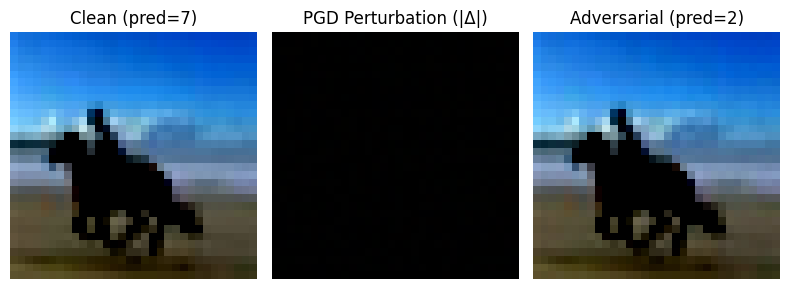

accuracy on PGD adversarial examples: 0.4375
accuracy on clean examples: 0.7188

PGD attack with alpha=0.005
PGD Adversarial predictions: 2 (bird)
Initial prediction: 7 (horse)
max |Δ|: 0.025000013411045074


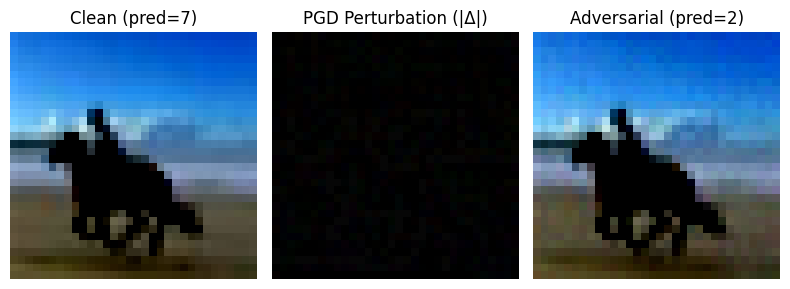

accuracy on PGD adversarial examples: 0.1562
accuracy on clean examples: 0.7188

PGD attack with alpha=0.01
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 7 (horse)
max |Δ|: 0.030000001192092896


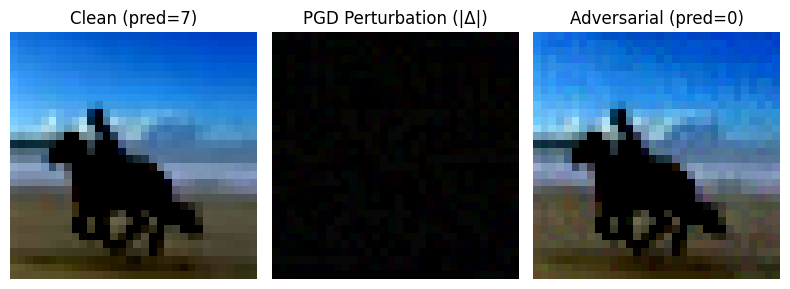

accuracy on PGD adversarial examples: 0.0938
accuracy on clean examples: 0.7188

PGD attack with alpha=0.02
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 7 (horse)
max |Δ|: 0.030000001192092896


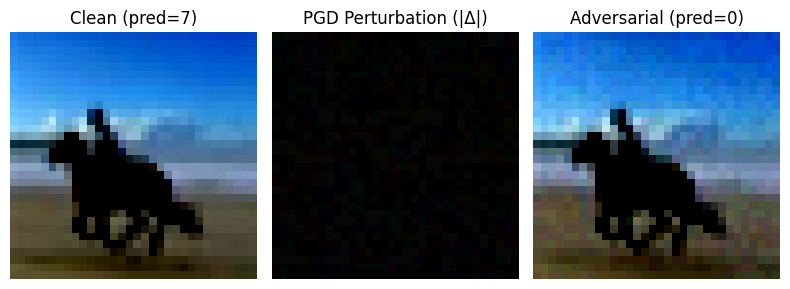

accuracy on PGD adversarial examples: 0.0938
accuracy on clean examples: 0.7188

PGD attack with alpha=0.03
PGD Adversarial predictions: 0 (airplane)
Initial prediction: 7 (horse)
max |Δ|: 0.030000001192092896


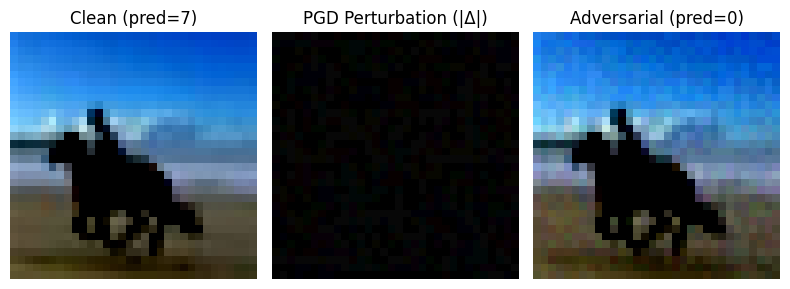

accuracy on PGD adversarial examples: 0.0938
accuracy on clean examples: 0.7188


In [215]:
for alpha in [0.001, 0.005, 0.01, 0.02, 0.03]:
    print(f"\nPGD attack with alpha={alpha}")
    pgd_images = pgd_attack(model, images, labels, epsilon=0.03, alpha=alpha, num_iter=5)
    pgd_outputs = model(pgd_images)
    _, pred_pgd = torch.max(pgd_outputs, 1)

    idx = 20  # choose which image to display

    print(f"PGD Adversarial predictions:", pred_pgd[idx].item(), f"({ class_names[pred_pgd[idx].item()]})")
    print(f"Initial prediction:", pred_clean[idx].item(), f"({ class_names[pred_clean[idx].item()]})")

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    show_image(images[idx], title=f"Clean (pred={pred_clean[idx].item()})")

    perturbation = pgd_images[idx] - images[idx]
    #print(perturbation)
    print("max |Δ|:", perturbation.abs().max().item())

    plt.subplot(1, 3, 2)
    show_image(perturbation, title="PGD Perturbation (|Δ|)")

    plt.subplot(1, 3, 3)
    show_image(pgd_images[idx], title=f"Adversarial (pred={pred_pgd[idx].item()})")

    plt.tight_layout()
    plt.show()

    print(f"accuracy on PGD adversarial examples: {accuracy_score(labels.cpu(), pred_pgd.cpu()):.4f}")
    print(f"accuracy on clean examples: {accuracy_clean:.4f}")

# 3. Data Poisoning Attacks (Training-Time Threats)
## 3.1 Label-Flipping Poisoning Experiment

In [222]:
import random

images, labels = next(iter(train_loader))

def poison_labels(labels, poison_rate=0.1):
    labels = labels.clone().detach().to(device)
    n_poison = int(len(labels) * poison_rate)
    for i in random.sample(range(len(labels)), n_poison):
        labels[i] = random.randint(0, 9)
    
    return labels

for poison_rate in [0.05, 0.15, 0.5]:
    print(f"\nPoisoning labels with poison rate={poison_rate}")
    poisoned_labels = poison_labels(labels, poison_rate=poison_rate)
    print(f"Original labels: {labels[:20].cpu().numpy()}")
    print(f"Poisoned labels: {poisoned_labels[:20].cpu().numpy()}")



Poisoning labels with poison rate=0.05
Original labels: [5 5 6 9 4 5 7 6 5 1 5 2 3 3 9 8 3 3 1 0]
Poisoned labels: [5 5 6 9 4 5 9 6 5 1 5 2 3 3 9 8 3 3 1 0]

Poisoning labels with poison rate=0.15
Original labels: [5 5 6 9 4 5 7 6 5 1 5 2 3 3 9 8 3 3 1 0]
Poisoned labels: [5 5 6 9 4 5 1 6 3 1 5 2 3 3 9 8 3 3 1 0]

Poisoning labels with poison rate=0.5
Original labels: [5 5 6 9 4 5 7 6 5 1 5 2 3 3 9 8 3 3 1 0]
Poisoned labels: [2 9 6 7 4 0 8 6 5 1 5 2 3 3 9 8 7 4 3 8]


In [223]:
### Recréer un modèle vierge pour l'entraînement avec les labels empoisonnés
poisonable_model = SimpleCNN(num_classes=10)

In [224]:
### Entraînement avec les labels empoisonnés 
# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
poisonable_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poisonable_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    poisonable_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        poisoned_labels = poison_labels(labels, poison_rate=0.05)  # Poison 5% of the labels
        optimizer.zero_grad()
        outputs = poisonable_model(inputs)
        loss = criterion(outputs, poisoned_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    poisonable_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = poisonable_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    for class_idx in range(len(class_total)):
        accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
        print(f"Validation Accuracy for class {class_idx}: {accuracy:.2f}%")


Epoch 1/10, Train Loss: 1.6260, Val Loss: 1.1951, Val Accuracy: 56.63%
Validation Accuracy for class 0: 53.39%
Validation Accuracy for class 1: 63.95%
Validation Accuracy for class 2: 27.76%
Validation Accuracy for class 3: 41.27%
Validation Accuracy for class 4: 48.73%
Validation Accuracy for class 5: 39.87%
Validation Accuracy for class 6: 73.71%
Validation Accuracy for class 7: 65.61%
Validation Accuracy for class 8: 81.12%
Validation Accuracy for class 9: 70.81%
Epoch 2/10, Train Loss: 1.2203, Val Loss: 1.0107, Val Accuracy: 64.95%
Validation Accuracy for class 0: 73.58%
Validation Accuracy for class 1: 76.50%
Validation Accuracy for class 2: 47.86%
Validation Accuracy for class 3: 55.62%
Validation Accuracy for class 4: 42.21%
Validation Accuracy for class 5: 52.42%
Validation Accuracy for class 6: 59.35%
Validation Accuracy for class 7: 82.35%
Validation Accuracy for class 8: 84.47%
Validation Accuracy for class 9: 73.86%
Epoch 3/10, Train Loss: 1.0413, Val Loss: 0.8945, Val Accu

In [225]:
# Save the trained model
torch.save(poisonable_model.state_dict(), 'poisoned_cnn_5.pth')
print("Model saved as poisoned_cnn_5%.pth")

Model saved as poisoned_cnn_5%.pth


In [226]:
# Load the trained model
poisoned_model = SimpleCNN(num_classes=10)
poisoned_model.load_state_dict(torch.load('poisoned_cnn_5.pth'))

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
poisoned_model.to(device)

poisoned_model.eval()

# Evaluate on the test set
correct = 0
total = 0
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = poisoned_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

for class_idx in range(len(class_total)):
    accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
    print(f"Test Accuracy for class {class_idx}: {accuracy:.2f}%")

Test Accuracy: 74.41%
Test Accuracy for class 0: 79.71%
Test Accuracy for class 1: 87.98%
Test Accuracy for class 2: 61.13%
Test Accuracy for class 3: 52.89%
Test Accuracy for class 4: 69.14%
Test Accuracy for class 5: 67.18%
Test Accuracy for class 6: 81.34%
Test Accuracy for class 7: 82.03%
Test Accuracy for class 8: 81.69%
Test Accuracy for class 9: 80.63%


In [ ]:
# Get predictions and calculate probabilities for ROC and Precision-Recall curves
all_labels = []
all_outputs = []
all_outputs_proba = []

poisoned_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = poisoned_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(predicted.cpu().numpy())
        all_outputs_proba.extend(outputs.cpu().numpy())

all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)
all_outputs_proba = np.array(all_outputs_proba)

# Get class names from the original dataset
class_names = full_dataset.classes